In [15]:
# basic
import pandas as pd
import numpy as np
import ast
import json

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [16]:
# convert string to dictionary
def to_dict(attribute):
    try:
        if attribute != None:
            return ast.literal_eval(attribute)
        else:
            return ast.literal_eval("{}")
    except Exception as ex:
        print(ex)

In [17]:
# importing restaurants
restaurant = pd.read_csv('restaurant.csv')

In [18]:
# expand out attributes and make them their own columns
restaurant['attributes'] = restaurant['attributes'].replace(r'^\s*$', np.nan, regex=True)
restaurant['attributes'] = restaurant['attributes'].where(pd.notnull(restaurant['attributes']), None)
attributes_dict = [to_dict(x) for x in restaurant['attributes']]
attributes = pd.DataFrame(attributes_dict)

pd.set_option('display.max_columns', None)

In [19]:
# expand out nested dictionaries like GoodForMeal and Ambience
attributes['GoodForMeal'] = attributes['GoodForMeal'].where(pd.notnull(attributes['GoodForMeal']), None)
gfm_dict = [to_dict(x) for x in attributes['GoodForMeal']]
gfm = pd.json_normalize(gfm_dict)
# print(gfm)

attributes['Ambience'] = attributes['Ambience'].where(pd.notnull(attributes['Ambience']), None)
a_dict = [to_dict(x) for x in attributes['Ambience']]
a = pd.json_normalize(a_dict)
# print(a)

attributes['BusinessParking'] = attributes['BusinessParking'].where(pd.notnull(attributes['BusinessParking']), None)
bp_dict = [to_dict(x) for x in attributes['BusinessParking']]
bp = pd.json_normalize(bp_dict)
# print(bp)

attributes['BestNights'] = attributes['BestNights'].where(pd.notnull(attributes['BestNights']), None)
bn_dict = [to_dict(x) for x in attributes['BestNights']]
bn = pd.json_normalize(bn_dict)
bn = bn.rename(columns={'monday': 'monday_bn', 'tuesday': 'tuesday_bn', 
                        'wednesday': 'wednesday_bn', 'thursday': 'thursday_bn', 
                        'friday': 'friday_bn', 'saturday': 'saturday_bn', 'sunday': 'sunday_bn'})
# print(bn)

attributes['Music'] = attributes['Music'].where(pd.notnull(attributes['Music']), None)
m_dict = [to_dict(x) for x in attributes['Music']]
m = pd.json_normalize(m_dict)
# print(m)

attributes['DietaryRestrictions'] = attributes['DietaryRestrictions'].where(pd.notnull(attributes['DietaryRestrictions']), None)
dr_dict = [to_dict(x) for x in attributes['DietaryRestrictions']]
dr = pd.json_normalize(dr_dict)
# print(dr)

# drop col in attributes
attributes = attributes.drop(['GoodForMeal', 'Ambience', 'BusinessParking', 'BestNights', 'Music', 'DietaryRestrictions'], 
                             axis=1)

# fuse together
attributes = pd.concat([attributes, gfm, a, bp, bn, m, dr], axis=1)

attributes

,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters,RestaurantsAttire,RestaurantsReservations,GoodForKids,CoatCheck,DogsAllowed,RestaurantsTableService,RestaurantsGoodForGroups,WheelchairAccessible,HasTV,HappyHour,DriveThru,NoiseLevel,BusinessAcceptsBitcoin,Smoking,GoodForDancing,BYOB,Corkage,BYOBCorkage,RestaurantsCounterService,Open24Hours,AgesAllowed,HairSpecializesIn,AcceptsInsurance,dessert,latenight,lunch,dinner,brunch,breakfast,romantic,intimate,touristy,hipster,divey,classy,trendy,upscale,casual,garage,street,validated,lot,valet,monday_bn,tuesday_bn,friday_bn,wednesday_bn,thursday_bn,sunday_bn,saturday_bn,dj,background_music,no_music,jukebox,live,video,karaoke,dairy-free,gluten-free,vegan,kosher,halal,soy-free,vegetarian
0,False,False,False,True,1,True,False,u'free',u'none',True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,True,True,False,1,True,False,u'no',u'none',False,u'casual',False,True,False,False,False,True,True,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,False,True,True,NaN,1,True,NaN,u'free',u'full_bar',True,u'casual',False,True,NaN,NaN,NaN,True,NaN,True,NaN,NaN,u'average',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,True,True,NaN,1,True,False,u'no',u'none',False,'casual',False,True,False,False,False,False,True,True,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,'none',NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52263,True,NaN,True,True,1,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52264,False,True,True,True,1,False,NaN,'free',u'none',False,'casual',False,True,NaN,NaN,NaN,True,NaN,False,NaN,NaN,u'loud',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52265,True,False,True,True,2,True,NaN,u'free',u'none',True,'casual',False,True,NaN,NaN,True,True,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,None,True,True,None,None,None,None,None,False,None,None,None,None,True,None,True,None,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52266,False,NaN,True,True,1,True,NaN,NaN,'none',True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,N

In [20]:
# one hot encode attributes
df = pd.get_dummies(attributes)
print(df)

counts = {}
for col in df:
    counts[col] = df[col].sum()
    
# sort
counts = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
# print(counts)

# drop any col with sum < 10000
for col in df:
    if df[col].sum() < 10000:
        df.drop(col, axis=1, inplace=True)

attributes = df
attributes

       RestaurantsDelivery_False  RestaurantsDelivery_None  \
0                              1                         0   
1                              0                         0   
2                              1                         0   
3                              0                         0   
4                              0                         0   
...                          ...                       ...   
52263                          0                         0   
52264                          1                         0   
52265                          0                         0   
52266                          1                         0   
52267                          0                         0   

       RestaurantsDelivery_True  OutdoorSeating_False  OutdoorSeating_None  \
0                             0                     1                    0   
1                             1                     0                    0   
2                    

,RestaurantsDelivery_False,RestaurantsDelivery_True,OutdoorSeating_False,OutdoorSeating_True,BusinessAcceptsCreditCards_True,BikeParking_True,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsTakeOut_True,WiFi_u'free',WiFi_u'no',Alcohol_u'full_bar',Alcohol_u'none',Caters_False,Caters_True,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',RestaurantsReservations_False,RestaurantsReservations_True,GoodForKids_True,RestaurantsTableService_True,RestaurantsGoodForGroups_True,WheelchairAccessible_True,HasTV_False,HasTV_True,NoiseLevel_u'average',dessert_False,latenight_False,lunch_False,lunch_True,dinner_False,dinner_True,brunch_False,breakfast_False,romantic_False,intimate_False,touristy_False,hipster_False,divey_False,classy_False,trendy_False,upscale_False,casual_False,casual_True,garage_False,street_False,street_True,validated_False,lot_False,lot_True,valet_False
0,1,0,1,0,0,1,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1
1,0,1,0,1,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,0,1,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1
3,0,1,0,1,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52263,0,1,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1
52264,1,0,0,1,1,1,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,1
52265,0,1,1,0,1,1,0,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1
52266,1,0,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1


In [21]:
# expand out categories and make them their own columns
# categories = pd.Series(restaurant['categories']).str.get_dummies(',')
# # drop columns that only contain zeros or 1
# categories = categories.loc[:, (categories != 0).any(axis=0)]
# categories

# expand out categories and make them their own columns
categories = pd.Series(restaurant['categories']).str.get_dummies(', ')

def toList(cat):
    return [x.strip() for x in cat.split(',')]

def toSeries(series):
    return pd.Series(x for _list in series for x in _list)

# categories
resCategories = restaurant['categories']
#categories
resCategories = resCategories.apply(toList)
resCategories = toSeries(resCategories)

cat = {}
for _, val in resCategories.items():
    if val in cat:
        cat[val] +=1
    else:
        cat.update({val:1})
        
cat = dict(sorted(cat.items(), key=lambda item: item[1]))

res = {key : val for key, val in cat.items() if not (isinstance(val, int) and (val < 1000))}

catKeys = list(res.keys())
catKeys.remove('Restaurants')
catKeys

categories = categories[catKeys]
categories

,Food Trucks,Juice Bars & Smoothies,Tacos,Soup,Arts & Entertainment,Ice Cream & Frozen Yogurt,Beer,Wine & Spirits,Vegetarian,Mediterranean,Pubs,Cocktail Bars,Diners,Steakhouses,Asian Fusion,Barbeque,Sushi Bars,Sports Bars,Japanese,Desserts,Bakeries,Specialty Food,Caterers,Delis,Cafes,Chicken Wings,Salad,Event Planning & Services,Chinese,Seafood,Coffee & Tea,Italian,Mexican,Burgers,American (New),Breakfast & Brunch,Fast Food,Pizza,American (Traditional),Bars,Sandwiches,Nightlife,Food
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52263,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
52264,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
52265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
52266,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [22]:
# fuse into one whole table and drop attributes, categories
restaurant = restaurant.drop(["attributes", "categories", "hours"], axis=1)
restaurant = pd.concat([restaurant, attributes, categories], axis=1)
restaurant

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,RestaurantsDelivery_False,RestaurantsDelivery_True,OutdoorSeating_False,OutdoorSeating_True,BusinessAcceptsCreditCards_True,BikeParking_True,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsTakeOut_True,WiFi_u'free',WiFi_u'no',Alcohol_u'full_bar',Alcohol_u'none',Caters_False,Caters_True,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',RestaurantsReservations_False,RestaurantsReservations_True,GoodForKids_True,RestaurantsTableService_True,RestaurantsGoodForGroups_True,WheelchairAccessible_True,HasTV_False,HasTV_True,NoiseLevel_u'average',dessert_False,latenight_False,lunch_False,lunch_True,dinner_False,dinner_True,brunch_False,breakfast_False,romantic_False,intimate_False,touristy_False,hipster_False,divey_False,classy_False,trendy_False,upscale_False,casual_False,casual_True,garage_False,street_False,street_True,validated_False,lot_False,lot_True,valet_False,Food Trucks,Juice Bars & Smoothies,Tacos,Soup,Arts & Entertainment,Ice Cream & Frozen Yogurt,Beer,Wine & Spirits,Vegetarian,Mediterranean,Pubs,Cocktail Bars,Diners,Steakhouses,Asian Fusion,Barbeque,Sushi Bars,Sports Bars,Japanese,Desserts,Bakeries,Specialty Food,Caterers,Delis,Cafes,Chicken Wings,Salad,Event Planning & Services,Chinese,Seafood,Coffee & Tea,Italian,Mexican,Burgers,American (New),Breakfast & Brunch,Fast Food,Pizza,American (Traditional),Bars,Sandwiches,Nightlife,Food
0,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,1,0,1,0,0,1,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,0,1,0,1,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1
2,8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,1,0,0,1,1,0,1,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0
3,9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,0,1,0,1,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
4,11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52263,150325,l9eLGG9ZKpLJzboZq-9LRQ,Wawa,19 N Bishop Ave,Clifton Heights,PA,19018,39.925656,-75.310344,3.0,11,1,0,1,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
52264,150327,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,1181 N Milwaukee St,Boise,ID,83704,43.615401,-116.284689,4.0,33,1,1,0,0,1,1,1,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

In [23]:
# creating x
x = restaurant.loc[:, 'review_count':]
# can change to whatever amount we consider as "good"
y = restaurant['stars'].apply(lambda x: 1 if x>=4 else 0)

# split!
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

dataColumns = xTrain.columns

# normalize
scaler = StandardScaler()
scaler.fit(xTrain)

xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

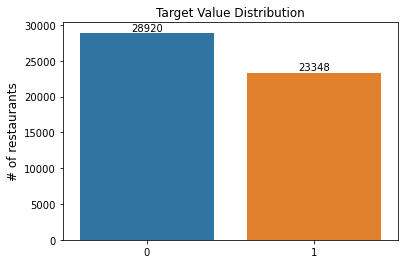

In [25]:
ax = sns.barplot(x=y.value_counts().index, y=y.value_counts())
plt.title("Target Value Distribution")
plt.ylabel("# of restaurants", fontsize=12)
for i in ax.containers:
    ax.bar_label(i,)

In [26]:
# KNN classifier
knn = KNeighborsClassifier()
knn.fit(xTrain, yTrain)

# predict
yHat = knn.predict(xTest)

# results
knn_accuracy = accuracy_score(yTest, yHat)
report = classification_report(yTest, yHat, digits=3)

print("accuracy: ", knn_accuracy)
print("Report:")
print(report)

accuracy:  0.6839487277597092
Report:
              precision    recall  f1-score   support

           0      0.698     0.754     0.725      8672
           1      0.662     0.597     0.628      7009

    accuracy                          0.684     15681
   macro avg      0.680     0.676     0.677     15681
weighted avg      0.682     0.684     0.682     15681



In [27]:
# KNN Hyperparameter Tuning
grid_params = {'n_neighbors': [5,7,9,11,13,15],
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'euclidean', 'manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1, cv=3, n_jobs=3)
grid.fit(xTrain, yTrain)
gridHat = grid.predict(xTest)

# results
grid_accuracy = accuracy_score(yTest, gridHat)
grid_report = classification_report(yTest, gridHat, digits=3)

print(grid.best_params_)
print("accuracy: ", grid_accuracy)
print("Grid Report:")
print(grid_report)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}
accuracy:  0.7002742172055354
Grid Report:
              precision    recall  f1-score   support

           0      0.704     0.790     0.745      8672
           1      0.694     0.589     0.637      7009

    accuracy                          0.700     15681
   macro avg      0.699     0.690     0.691     15681
weighted avg      0.700     0.700     0.697     15681



In [28]:
# Decision Tree classifier
dt = DecisionTreeClassifier()
dt.fit(xTrain, yTrain)

# predict
yHat = dt.predict(xTest)

# results
dt_accuracy = accuracy_score(yTest, yHat)
report = classification_report(yTest, yHat, digits=3)

print("accuracy: ", dt_accuracy)
print("Report:")
print(report)

accuracy:  0.6305082584018876
Report:
              precision    recall  f1-score   support

           0      0.666     0.665     0.666      8672
           1      0.587     0.587     0.587      7009

    accuracy                          0.631     15681
   macro avg      0.626     0.626     0.626     15681
weighted avg      0.631     0.631     0.631     15681



In [29]:
# Decision Tree Hyperparameter Tuning
grid_params = {'max_depth': [2,3,5,10,20],
              'min_samples_leaf': [5,10,20,50,100],
              'criterion': ['gini', 'entropy']}
grid = GridSearchCV(DecisionTreeClassifier(), grid_params, verbose=1, cv=3, n_jobs=3)
grid.fit(xTrain, yTrain)
gridHat = grid.predict(xTest)

# results
grid_accuracy = accuracy_score(yTest, gridHat)
grid_report = classification_report(yTest, gridHat, digits=3)

print(grid.best_params_)
print("accuracy: ", grid_accuracy)
print("Grid Report:")
print(grid_report)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 50}
accuracy:  0.6900070148587463
Grid Report:
              precision    recall  f1-score   support

           0      0.705     0.757     0.730      8672
           1      0.669     0.608     0.637      7009

    accuracy                          0.690     15681
   macro avg      0.687     0.682     0.683     15681
weighted avg      0.689     0.690     0.688     15681



In [30]:
# Logistic Regression classifier
lr = LogisticRegression()
lr.fit(xTrain, yTrain)

# predict
yHat = lr.predict(xTest)

# results
lr_accuracy = accuracy_score(yTest, yHat)
report = classification_report(yTest, yHat, digits=3)

print("accuracy: ", lr_accuracy)
print("Report:")
print(report)

accuracy:  0.7097123907914036
Report:
              precision    recall  f1-score   support

           0      0.724     0.769     0.745      8672
           1      0.690     0.637     0.662      7009

    accuracy                          0.710     15681
   macro avg      0.707     0.703     0.704     15681
weighted avg      0.709     0.710     0.708     15681



In [22]:
# Logistic Regression Hyperparameter Tuning
grid_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
               'C' : np.logspace(-4, 4, 20),
               'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
               'max_iter' : [100, 1000,2500, 5000]}
grid = GridSearchCV(LogisticRegression(), grid_params, verbose=1, cv=3, n_jobs=3)
grid.fit(xTrain, yTrain)
gridHat = grid.predict(xTest)

# results
grid_accuracy = accuracy_score(yTest, gridHat)
grid_report = classification_report(yTest, gridHat, digits=3)

print(grid.best_params_)
print("accuracy: ", grid_accuracy)
print("Grid Report:")
print(grid_report)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


C:\Users\choje\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2160 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\choje\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\choje\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\choje\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(


{'C': 0.08858667904100823, 'max_iter': 2500, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy:  0.6955833333333333
Grid Report:
              precision    recall  f1-score   support

           0      0.715     0.743     0.728      6596
           1      0.670     0.638     0.654      5404

    accuracy                          0.696     12000
   macro avg      0.692     0.690     0.691     12000
weighted avg      0.695     0.696     0.695     12000



In [31]:
# Gradient Boosting classifier
gb = GradientBoostingClassifier()
gb.fit(xTrain, yTrain)

# predict
yHat = gb.predict(xTest)

# results
gb_accuracy = accuracy_score(yTest, yHat)
report = classification_report(yTest, yHat, digits=3)

print("accuracy: ", gb_accuracy)
print("Report:")
print(report)

accuracy:  0.7121994770741662
Report:
              precision    recall  f1-score   support

           0      0.723     0.777     0.749      8672
           1      0.696     0.633     0.663      7009

    accuracy                          0.712     15681
   macro avg      0.710     0.705     0.706     15681
weighted avg      0.711     0.712     0.710     15681



In [33]:
# Gradient Boosting Hyperparameter Tuning
grid_params = {'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500],
              'max_leaf_nodes': [2, 5, 10, 20, 50, 100],
              'learning_rate': [0.01, 0.1, 1, 10]}
grid = HalvingGridSearchCV(GradientBoostingClassifier(), grid_params, verbose=1, cv=3, n_jobs=3)
grid.fit(xTrain, yTrain)
gridHat = grid.predict(xTest)

# results
grid_accuracy = accuracy_score(yTest, gridHat)
grid_report = classification_report(yTest, gridHat, digits=3)

print(grid.best_params_)
print("accuracy: ", grid_accuracy)
print("Grid Report:")
print(grid_report)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 451
max_resources_: 36587
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 216
n_resources: 451
Fitting 3 folds for each of 216 candidates, totalling 648 fits
----------
iter: 1
n_candidates: 72
n_resources: 1353
Fitting 3 folds for each of 72 candidates, totalling 216 fits
----------
iter: 2
n_candidates: 24
n_resources: 4059
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 3
n_candidates: 8
n_resources: 12177
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 4
n_candidates: 3
n_resources: 36531
Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'learning_rate': 0.1, 'max_leaf_nodes': 100, 'n_estimators': 200}
accuracy:  0.7192781072635673
Grid Report:
              precision    recall  f1-score   support

           0      0.732     0.776     0.753      8672
           1      0.701     0.649     0.674      7009

   

In [34]:
#PCA
def PCA95(xTrain, pca):
    pca.fit(xTrain)
    print(pca.explained_variance_ratio_.cumsum())
    return pca.components_

In [35]:
pca = PCA(n_components=56)
components= PCA95(xTrain, pca)
components

[0.11214646 0.17109059 0.21139066 0.24936869 0.28186416 0.3108685
 0.33686205 0.36007083 0.38124112 0.40180297 0.42221512 0.44045991
 0.45824898 0.47506064 0.49113661 0.50661057 0.52154824 0.53620397
 0.55023277 0.56402679 0.57706395 0.58985009 0.60222523 0.61397357
 0.62555669 0.63684984 0.64789907 0.65865497 0.66916695 0.67959842
 0.68982327 0.69994847 0.70996658 0.71954536 0.72900098 0.73823841
 0.74736537 0.75623917 0.76498814 0.77366236 0.78225284 0.79067899
 0.79871523 0.80657562 0.81439717 0.82207165 0.8296063  0.83702774
 0.8443656  0.85159968 0.85869616 0.86565756 0.87246887 0.87924231
 0.88580542 0.89226544]


array([[-0.07564319,  0.02130448, -0.04797077, ..., -0.00347776,
        -0.04205586,  0.02889389],
       [ 0.15408281,  0.00228853,  0.03870828, ..., -0.07335975,
         0.26160875, -0.03281105],
       [ 0.06151862,  0.19056313, -0.17262162, ...,  0.08227477,
        -0.03994976,  0.1054842 ],
       ...,
       [ 0.20255657,  0.12395172,  0.03885571, ...,  0.10573523,
        -0.00478509, -0.02374099],
       [ 0.29569965,  0.15632118,  0.07607606, ..., -0.40501095,
        -0.01221301,  0.00198907],
       [ 0.15004809,  0.16177285,  0.06437178, ...,  0.46545782,
        -0.03063145, -0.07288747]])

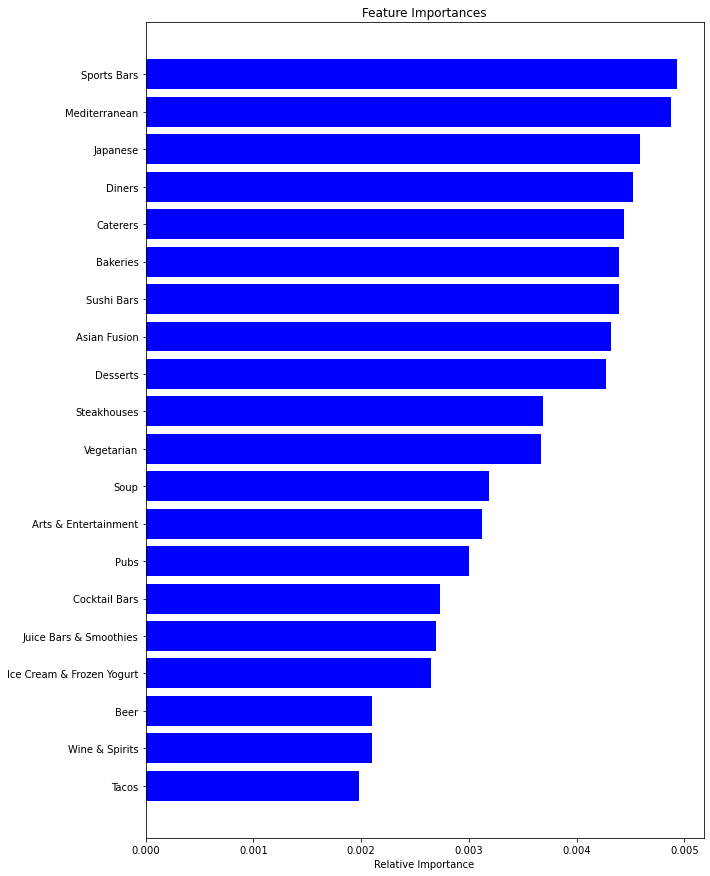

In [36]:
#plotting best features with random forest

model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model.fit(xTrain, yTrain)
# plotting feature importances
features = dataColumns
importances = model.feature_importances_
indices = np.argsort(importances)
indices = indices[0:20]
plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig("FeatImportance.png")
#plt.show()
